# Multimodal Regression with CGAN

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
f1 = lambda x: x ** 2 - 1
f2 = lambda x: x ** 3 

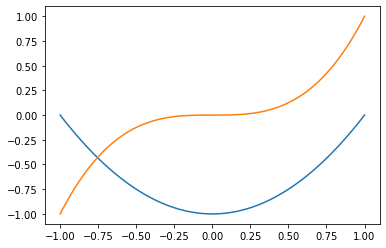

In [3]:
x = np.linspace(-1, 1, 100)
plt.plot(x, f1(x), x, f2(x))
plt.show()

# Generate Dataset

In [4]:
x = np.linspace(-1, 1, 200).reshape(-1, 1)
np.random.shuffle(x)
x1, x2 = x[:100], x[100:]
y1, y2 = f1(x1) + 0.05*np.random.randn(100, 1), f2(x2) + 0.05*np.random.randn(100, 1)

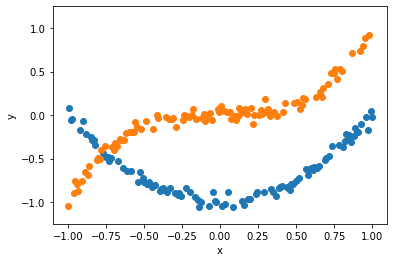

In [5]:
plt.scatter(x1, y1)
plt.scatter(x2, y2)
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-1.25, 1.25)
plt.show()

In [6]:
xs = torch.tensor(np.concatenate([x1, x2]), dtype=torch.float)
ys = torch.tensor(np.concatenate([y1, y2]), dtype=torch.float)

In [7]:
x_train = xs
y_train = ys
# idx = torch.randperm(len(xs))
# x_train, x_test = xs[idx[:150]], xs[idx[150:]]
# y_train, y_test = ys[idx[:150]], ys[idx[150:]]

# Traditional Unimodal Regression
Gaussian regression model

In [8]:
class MLP(nn.Module):
    def __init__(self, width=100):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, width),
            nn.ELU(),
            nn.Linear(width, 1)
        )
    
    def forward(self, input):
        return self.model(input)

In [9]:
model = MLP(200)
mse = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.01)

for epoch in range(500):
    optimizer.zero_grad()
    loss = mse(y_train, model(x_train))
    loss.backward()
    optimizer.step()
    if (epoch+1) % 50 == 0:
        print('Epoch {}: MSE = {}'.format(epoch, loss))

Epoch 49: MSE = 0.1734292358160019
Epoch 99: MSE = 0.17040543258190155
Epoch 149: MSE = 0.16977782547473907
Epoch 199: MSE = 0.16914911568164825
Epoch 249: MSE = 0.16855816543102264
Epoch 299: MSE = 0.16802391409873962
Epoch 349: MSE = 0.1675550788640976
Epoch 399: MSE = 0.16717571020126343
Epoch 449: MSE = 0.16690193116664886
Epoch 499: MSE = 0.16671648621559143


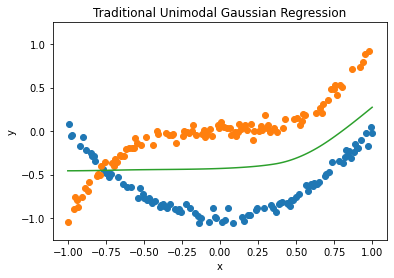

In [10]:
xp = torch.linspace(-1, 1, 100).unsqueeze(-1)
plt.scatter(x1, y1)
plt.scatter(x2, y2)
plt.plot(xp, model(xp).detach(), c='tab:green')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-1.25, 1.25)
plt.title('Traditional Unimodal Gaussian Regression')
plt.show()

## Conclusion
The unimodal regression model is not able to fit the conditonal distribution.

# Multimodal Regression Model: Conditional EGAN
## Define Generator

In [11]:
class Generator(nn.Module):
    def __init__(self, in_features=2, width=100):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, width),
            nn.BatchNorm1d(width),
            nn.ReLU(),
            nn.Linear(width, width),
            nn.BatchNorm1d(width),
            nn.ReLU(),
            nn.Linear(width, width),
            nn.BatchNorm1d(width),
            nn.ReLU(),
            nn.Linear(width, width),
            nn.BatchNorm1d(width),
            nn.ReLU(),
            nn.Linear(width, 1)
        )
    
    def forward(self, condition, noise):
        input = torch.hstack([noise, condition])
        return self.model(input)

## Define Sinkhorn Divergence

In [12]:
def lse(V):
    v_m = torch.max(V, dim=1, keepdim=True).values
    return v_m + (V - v_m).exp().sum(dim=1, keepdim=True).log()

def sink_maps(x, y, eps, p):
    C = torch.norm(x.unsqueeze(1) - y.unsqueeze(0), dim=2, p=p) / eps
    S_f = lambda g: -lse(g.view(1, -1) - C)
    S_g = lambda f: -lse(f.view(1, -1) - C.T)
    return S_f, S_g

def sink(a, x, b, y, p=2, eps=1, iter=100, tol=1e-3, converge=True):
    a_log, b_log = a.log(), b.log()
    f, g = torch.zeros_like(a), torch.zeros_like(b)
    S_f, S_g = sink_maps(x, y, eps, p)
    with torch.set_grad_enabled(not converge):
        for i in range(iter):
            g_old = g
            f = S_f(g + b_log)
            g = S_g(f + a_log)
            if eps * (g - g_old).abs().mean() < tol: break
    if not converge:
        return eps * S_f(g + b_log), eps * S_g(f + a_log)
    else:
        S_f, _ = sink_maps(x.detach(), y, eps, p)
        _, S_g = sink_maps(x, y.detach(), eps, p)
        return eps * S_f((g + b_log).detach()), eps * S_g((f + a_log).detach())

def entropic_ot(a, x, b, y, **kwargs):
    f, g = sink(a, x, b, y, **kwargs)
    return f.T @ a + g.T @ b

def sinkhorn_divergence(a, x, b, y, **kwargs):
    return entropic_ot(a, x, b, y, **kwargs) \
        - 0.5 * entropic_ot(a, x, a, x, **kwargs) \
        - 0.5 * entropic_ot(b, y, b, y, **kwargs)

## Training

In [13]:
gen = Generator(2, 100)
def sd(x, real_y, fake_y):
    input1 = torch.hstack([x, real_y])
    input2 = torch.hstack([x, fake_y])
    a = torch.ones(len(input1), 1) / len(input1)
    b = torch.ones(len(input2), 1) / len(input2)
    return sinkhorn_divergence(a, input1, b, input2, p=2)

optimizer = torch.optim.Adam(gen.parameters(), 3e-4)

for epoch in range(1000):
    optimizer.zero_grad()
    loss = sd(x_train, y_train, gen(x_train, torch.randn_like(x_train)))
    loss.backward()
    optimizer.step()
    if (epoch+1) % 50 == 0:
        print('Epoch {}: SD = {}'.format(epoch, loss.detach().item()))

Epoch 49: SD = 0.0035077333450317383
Epoch 99: SD = 0.0029029548168182373
Epoch 149: SD = 0.0022092461585998535
Epoch 199: SD = 0.00156325101852417
Epoch 249: SD = 0.0024394690990448
Epoch 299: SD = 0.0016816258430480957
Epoch 349: SD = 0.0019396543502807617
Epoch 399: SD = 0.001248180866241455
Epoch 449: SD = 0.0013812780380249023
Epoch 499: SD = 0.0014004409313201904
Epoch 549: SD = 0.0018170475959777832
Epoch 599: SD = 0.0021008551120758057
Epoch 649: SD = 0.002156585454940796
Epoch 699: SD = 0.0016833245754241943
Epoch 749: SD = 0.0014494061470031738
Epoch 799: SD = 0.0027698874473571777
Epoch 849: SD = 0.0018191933631896973
Epoch 899: SD = 0.0020485520362854004
Epoch 949: SD = 0.0020915567874908447
Epoch 999: SD = 0.0024136006832122803


## Result

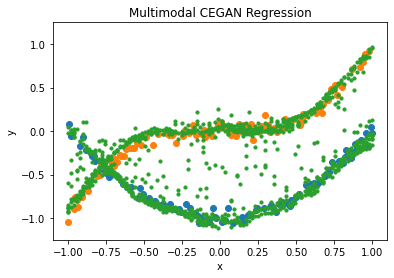

In [14]:
xpr = xp.expand(-1, 10).reshape(-1, 1)
plt.scatter(x1, y1)
plt.scatter(x2, y2)
plt.scatter(xpr, gen(xpr, torch.randn_like(xpr)).detach(), s=10)
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-1.25, 1.25)
plt.title('Multimodal CEGAN Regression')
plt.show()

# Multimodal Regression Model: Conditional GAN
## Define Discriminator

In [21]:
class Discriminator(nn.Module):
    def __init__(self, in_features=2, width=100):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, width),
            # nn.BatchNorm1d(width),
            nn.ReLU(),
            nn.Linear(width, width),
            # nn.BatchNorm1d(width),
            nn.ReLU(),
            nn.Linear(width, width),
            # nn.BatchNorm1d(width),
            nn.ReLU(),
            nn.Linear(width, width),
            # nn.BatchNorm1d(width),
            nn.ReLU(),
            nn.Linear(width, 1)
        )
    
    def forward(self, condition, pred):
        input = torch.hstack([pred, condition])
        return self.model(input)

In [22]:
dis = Discriminator(2, 100)
gen_v = Generator(2, 100)

## Define Minimax Game

In [23]:
import torch.nn.functional as F

def js_loss_D(condition, real, fake):
    return F.binary_cross_entropy_with_logits(dis(condition, real), torch.ones(len(real), 1, device=real.device)) \
        + F.binary_cross_entropy_with_logits(dis(condition, fake), torch.zeros(len(fake), 1, device=fake.device))

def js_loss_G(condition, fake):
    return - F.binary_cross_entropy_with_logits(dis(condition, fake), torch.zeros(len(fake), 1, device=fake.device))
    # return F.binary_cross_entropy_with_logits(dis(condition, fake), torch.ones(len(fake), 1, device=fake.device))

## Training

In [24]:
optimizer_D = torch.optim.Adam(dis.parameters(), 3e-4)
optimizer_G = torch.optim.Adam(gen_v.parameters(), 3e-4)

for epoch in range(1000):
    for _ in range(10):
        optimizer_D.zero_grad()
        d_loss = js_loss_D(x_train, y_train, gen_v(x_train, torch.randn_like(x_train)))
        d_loss.backward()
        optimizer_D.step()
    for _ in range(1):
        optimizer_G.zero_grad()
        g_loss = js_loss_G(x_train, gen_v(x_train, torch.randn_like(x_train)))
        g_loss.backward()
        optimizer_G.step()
    if (epoch+1) % 100 == 0:
        print('Epoch {}: JS_Loss = {}'.format(epoch, d_loss))

Epoch 99: JS_Loss = 1.1231341361999512
Epoch 199: JS_Loss = 1.2285356521606445
Epoch 299: JS_Loss = 1.1285672187805176
Epoch 399: JS_Loss = 1.2561862468719482
Epoch 499: JS_Loss = 1.0569289922714233
Epoch 599: JS_Loss = 1.135406255722046
Epoch 699: JS_Loss = 1.2349085807800293
Epoch 799: JS_Loss = 1.1296887397766113
Epoch 899: JS_Loss = 1.1675302982330322
Epoch 999: JS_Loss = 1.2007520198822021


## Result

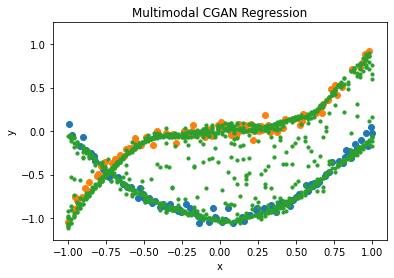

In [25]:
plt.scatter(x1, y1)
plt.scatter(x2, y2)
plt.scatter(xpr, gen_v(xpr, torch.randn_like(xpr)).detach(), s=10)
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-1.25, 1.25)
plt.title('Multimodal CGAN Regression')
plt.show()